# Particle Swarm Optimization (PSO)

MGSurvE also contains a beta implementation of a PSO algorithm as an alternative to the base GA.

Special thanks to Lillian Weng, Ayden Salazar, Xingli Yu, Topiltzin Hernandes, Joanna Yoo, and Elijah Bartolome for this implementation.

In [1]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
# Load libraries --------------------------------------------------------------
from os import path
import numpy as np
import pandas as pd
import MGSurvE as srv
from math import sqrt, inf
import matplotlib.pyplot as plt
# Setup data path and ID ------------------------------------------------------
(ID, LND_TOP, OUT_PTH) = ('pso', 'Uniform', './out/')
srv.makeFolder(OUT_PTH)

This time we will allow the setup of three different types of synthetic landscapes:
* `"Grid"`: A regular grid of points laid across a rectangular setup.
* `"Uniform"`: A sample of points uniformly sampled from a rectangular set of coordinates.
* `"Ring"`: A random sample of points laid along a ring with an iner and outer radius.

In [2]:
PTS_NUM = 100
RADII = (425, 500)
BBOX = ((-500, 500), (-350, 350))
# Generate Synthetic Pointset -------------------------------------------------
if LND_TOP == 'Grid':
    (ptsNum, ptsTypes) = (int(sqrt(PTS_NUM)), 1)
    xy = srv.ptsRegularGrid(PTS_NUM, (BBOX[0], BBOX[0])).T
elif LND_TOP == 'Uniform':
    (ptsNum, ptsTypes) = (PTS_NUM, 1)
    xy = srv.ptsRandUniform(ptsNum, BBOX).T
elif LND_TOP == 'Ring':
    (ptsNum, radii, ptsTypes) = (PTS_NUM, RADII, 1)
    xy = srv.ptsDonut(ptsNum, radii).T
pType = np.random.choice(ptsTypes, xy.shape[1])
points = pd.DataFrame({'x': xy[0], 'y': xy[1], 't': pType})
mKer = {'params': [.075, 1.0e-10, inf], 'zeroInflation': .75}

We will optimize five traps with two different exponentially-decaying attractiveness kernels:

In [3]:
# Traps -----------------------------------------------------------------------
traps = pd.DataFrame({
    'x': [0, 0, 0, 0, 0], 
    'y': [0, 0, 0, 0, 0],
    't': [0, 1, 0, 1, 0], 
    'f': [0, 0, 0, 0, 0]
})
tKer = {
    0: {'kernel': srv.exponentialDecay, 'params': {'A': .75, 'b': .025}},
    1: {'kernel': srv.exponentialDecay, 'params': {'A': .50, 'b': .015}}
}
# Landscape -------------------------------------------------------------------
lnd = srv.Landscape(
    points, 
    kernelParams=mKer,
    traps=traps, trapsKernels=tKer
)
bbox = lnd.getBoundingBox()

In [4]:
GENS = 400
# PSO -------------------------------------------------------------------------
(GENS, PARTS, SPD, PHI) = (
    GENS, traps.shape[0]*20,
    (-max(max(bbox))/30, max(max(bbox))/30),
    (max(max(bbox))/15, max(max(bbox))/15)
)
pso = srv.Particle_Swarm(
    lnd=lnd, traps=traps,
    num_particles=PARTS, num_gens=GENS, 
    p_min=min(bbox[0][0], bbox[1][0]), p_max=max(bbox[1][0], bbox[1][1]),  
    s_min=SPD[0], s_max=SPD[1],
    phi1=PHI[0], phi2=PHI[1],
    optimFunctionArgs={'inner': np.sum, 'outer': np.max}
)
(pop, logbook, _) = pso.evaluate()
best = list(logbook[logbook['min']==min(logbook['min'])]['traps'])[0]
bestTraps = np.reshape(best, (-1, 2))
lnd.updateTrapsCoords(bestTraps)


gen	evals	min    	avg    	max    	std    	best	traps                                                                                                                                                                                                  
0  	100  	154.407	3129.43	32043.5	5515.11	78  	[148.74411650416727, 233.36386473916298, 47.73558768967689, -166.6778389322514, -452.5602592301376, -253.6021890871656, 110.11201228682539, -427.72879464937347, -380.3512441877706, 97.88848539715946]
1  	100  	147.3  	3083.16	29805.6	5438.16	78  	[153.76696466844078, 239.70560200376505, 40.62645665999959, -177.37036635173934, -450.6361016847775, -259.02099270248954, 119.87115980522384, -430.69636946892365, -370.88637272204414, 107.60907921973359]
2  	100  	140.246	3058.11	27400.4	5396.92	78  	[158.7898128327143, 246.04733926836712, 33.51732563032229, -188.06289377122727, -448.71194413941737, -264.4397963178135, 129.6303073236223, -433.66394428847383, -361.4215012563177, 117.32967304230772]   
3  	

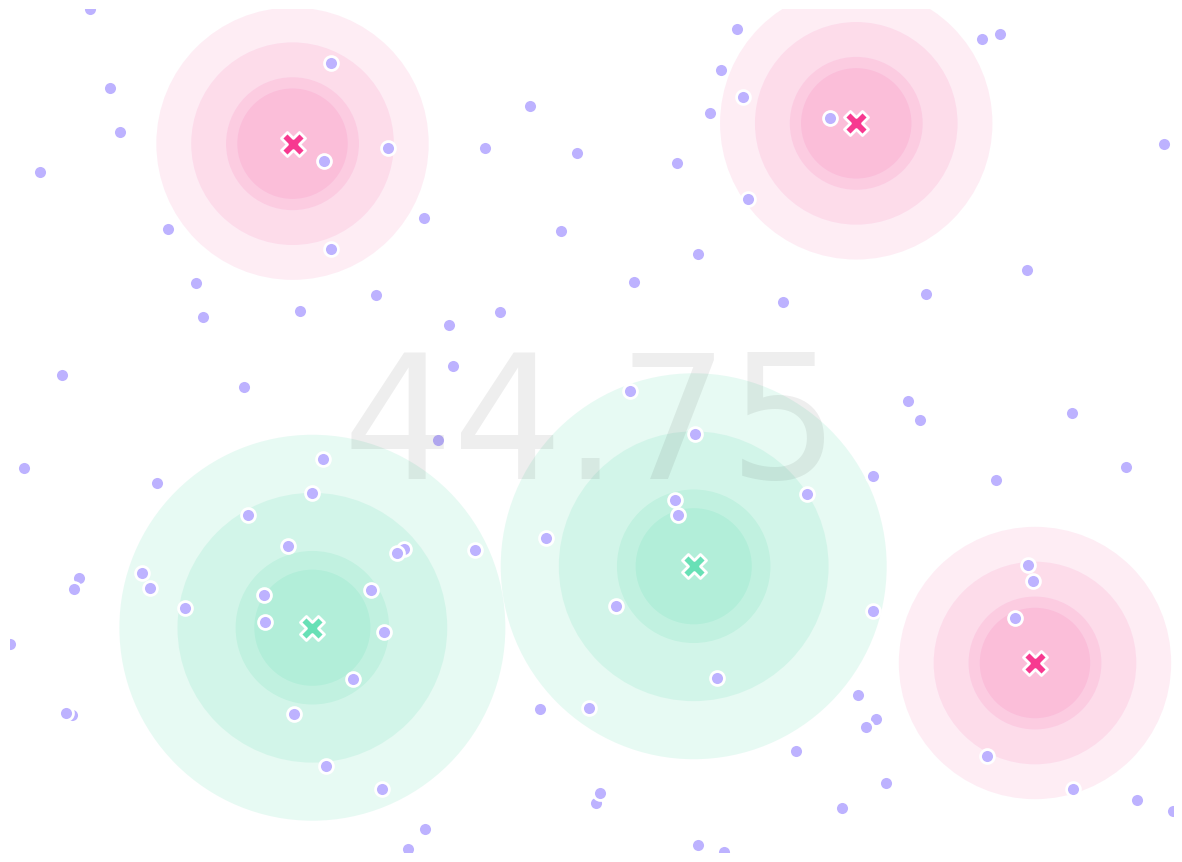

In [5]:
# Export Results --------------------------------------------------------------
dta = pd.DataFrame(logbook)
srv.dumpLandscape(lnd, OUT_PTH, '{}_{}-TRP'.format(ID, LND_TOP), fExt='pkl')
srv.exportLog(logbook, OUT_PTH, '{}_{}-LOG'.format(ID, LND_TOP))
# Plot Results ----------------------------------------------------------------
(fig, ax) = plt.subplots(1, 1, figsize=(15, 15), sharey=False)
lnd.plotSites(fig, ax, size=100)
# lnd.plotMigrationNetwork(fig, ax, alphaMin=.6, lineWidth=25)
lnd.plotTraps(fig, ax)
srv.plotFitness(fig, ax, min(logbook['min']), zorder=30)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}_{}-TRP.png'.format(ID, LND_TOP)),
    facecolor='w', bbox_inches='tight', 
    pad_inches=0, dpi=300
)